Most of the contents of this notebook are now also in optuna.ipynb, to get all of the results in the same dataframe. Confusion matrices for the word embeddings models are only in this notebook.

This notebook tunes different logistic regression classification models (with input made from word embeddings) with Optuna. 

The input to the model differs in the following ways:
- Vectorization is done by making document vectors by averaging over pretrained word embeddings from Gensim
- Vectorization is done by making document vectors, but before averaging over the pretrained word embeddings, scale the embeddings by multiplying the with the TfIdf weights.

The labels are set the following way:
- To get the label Male/Female there must be at least 70% of the applicants that are male/female. Otherwise label is Neutral.

The best results (91% accuracy) were gotten with input that had document vectors made from TfIdf-scaled word embeddings.

In [ ]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination")
import warnings

import gensim
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv("data/cleaned_data/bulletins_w_labels_and_content.csv", dtype={'ID': object})  
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...


In [74]:
corpus = list(df["Cleaned text"])
len(corpus)

177

In [5]:
#vectorizer = CountVectorizer()

In [6]:
#X = vectorizer.fit_transform(corpus)

In [7]:
# count_vectorized_data = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# count_vectorized_data["Label"] = df["Label 70/30"]
# print(count_vectorized_data.shape)
# count_vectorized_data.head()

(177, 3836)


,ab,abatement,abbreviation,abilities,ability,able,absence,absorption,abuse,ac,...,xv,xvi,yard,year,yearly,yield,youth,zero,zone,Label
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,N
1,0,0,0,1,0,2,0,0,0,0,...,0,0,0,3,0,0,0,0,0,W
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,M
3,0,0,0,1,4,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,M
4,0,0,0,0,2,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,N


In [8]:
google_model = gensim.models.KeyedVectors.load_word2vec_format("c:/Users/britt/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [9]:
#words_vocab = count_vectorized_data.columns[:-1]

In [10]:
#words_vocab[:10]

Index(['ab', 'abatement', 'abbreviation', 'abilities', 'ability', 'able',
       'absence', 'absorption', 'abuse', 'ac'],
      dtype='object')

In [11]:
# # Defining a function which takes text input and returns one vector for each sentence
# def text2vec(docs):
#     # Converting the text to numeric data
#     X = vectorizer.transform(docs)
#     count_vec_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
#     # Creating empty dataframe to hold sentences
#     word2vec_df = pd.DataFrame()
    
#     # Looping through each row for the data
#     for i in range(count_vec_df.shape[0]):
 
#         # initiating a sentence with all zeros
#         sentence = np.zeros(300)
 
#         # Looping thru each word in the sentence and if its present in 
#         # the Word2Vec model then storing its vector
#         for word in words_vocab[count_vec_df.iloc[i,:]]:
#             #print(word)
#             if word in google_model.key_to_index.keys():    
#                 sentence = sentence + google_model[word]
#         # Appending the sentence to the dataframe
#         word2vec_df.append(pd.DataFrame([sentence]))
    
#     return word2vec_df


In [12]:
#word2vec_df = text2vec(df["Cleaned text"])

In [13]:
#word2vec_df.shape

(0, 0)

In [60]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit_transform(corpus)

<177x3835 sparse matrix of type '<class 'numpy.float64'>'
	with 68003 stored elements in Compressed Sparse Row format>

In [122]:
vocabulary = tfidf_vectorizer.get_feature_names_out()
documents_embeddings = []
documents_scaled_embeddings = []
for doc in corpus:
    word_embeddings = []
    scaled_embeddings  = []
    doc_list = doc.split()
    for word in doc_list:
        if word in google_model.key_to_index.keys():
            embedding = google_model[word]
            word_embeddings.append(embedding)
            index = np.where(vocabulary == word)[0]
            try:
                scaled_embeddings.append(embedding * tfidf_vectorizer.idf_[index])
            except ValueError:
                pass
    documents_embeddings.append(word_embeddings)
    documents_scaled_embeddings.append(scaled_embeddings)

In [86]:
len(documents_embeddings)

177

In [87]:
len(documents_scaled_embeddings)

177

In [129]:
embeddings_df = pd.DataFrame(documents_embeddings)

In [130]:
embeddings_df.shape

(177, 1691)

In [131]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690
0,"[-0.040283203, -0.32226562, 0.040527344, -0.12...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[0.0390625, 0.01586914, -0.07373047, 0.1855468...","[0.3984375, -0.056152344, -0.16894531, 0.18359...","[0.3203125, 0.048583984, -0.031982422, -0.1464...","[-0.040283203, -0.32226562, 0.040527344, -0.12...","[-0.068847656, -0.19824219, 0.36914062, -0.199...",...,None,None,None,None,None,None,None,None,None,None
1,"[-0.020141602, 0.060302734, 0.028686523, 0.026...","[0.11279297, -0.14355469, -0.3671875, 0.002624...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[-0.076660156, 0.15234375, -0.15234375, 0.1166...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[-0.20605469, -0.06689453, 0.12060547, 0.01281...","[-0.096191406, 0.03515625, 0.010864258, 0.0622...",...,None,None,None,None,None,None,None,None,None,None
2,"[0.06201172, -0.030395508, 0.080078125, 0.0546...","[-0.1640625, -0.061767578, -0.05419922, -0.376...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[-0.076660156, 0.15234375, -0.15234375, 0.1166...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[-0.20605469, -0.06689453, 0.12060547, 0.01281...","[-0.096191406, 0.03515625, 0.010864258, 0.0622...",...,None,None,None,None,None,None,None,None,None,None
3,"[0.06201172, -0.030395508, 0.080078125, 0.0546...","[0.09277344, 0.080078125, 0.13671875, -0.33203...","[0.25, -0.005554199, -0.02746582, -0.20214844,...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[-0.076660156, 0.15234375, -0.15234375, 0.1166...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[-0.096191406, 0.03515625, 0.010864258, 0.0622...",...,None,None,None,None,None,None,None,None,None,None
4,"[-0.15917969, 0.009338379, -0.34179688, -0.177...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[0.0390625, 0.01586914, -0.07373047, 0.1855468...","[0.3984375, -0.056152344, -0.16894531, 0.18359...","[0.013305664, -0.25976562, 0.09716797, 0.00891...","[0.014282227, -0.088378906, -0.052246094, 0.12...","[-0.07470703, 0.26171875, 0.08251953, -0.02917...",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,"[-0.39453125, 0.18066406, 0.33203125, -0.40625...","[-0.24023438, 0.37890625, 0.08105469, 0.133789...","[-0.35742188, 0.0047302246, 0.234375, 0.071289...","[-0.1640625, -0.061767578, -0.05419922, -0.376...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[-0.076660156, 0.15234375, -0.15234375, 0.1166...","[-0.037841797, -0.075683594, 0.13085938, 0.067...",...,None,None,None,None,None,None,None,None,None,None
173,"[-0.39453125, 0.18066406, 0.33203125, -0.40625...","[-0.24023438, 0.37890625, 0.08105469, 0.133789...","[-0.15820312, -0.3359375, 0.084472656, -0.0908...","[-0.080566406, 0.21484375, -0.060546875, 0.239...","[0.19921875, -0.1171875, 0.34765625, -0.016113...","[-0.037841797, -0.075683594, 0.13085938, 0.067...","[0.028320312, 0.018554688, 0.20703125, 0.05346...","[-0.076660

In [88]:
df["Embeddings"] = documents_embeddings
df["Scaled embeddings"] = documents_scaled_embeddings

In [89]:
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text,Embeddings,Scaled embeddings
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...,"[[-0.040283203, -0.32226562, 0.040527344, -0.1...","[[-0.14271235996378817, -1.1416988797103054, 0..."
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...,"[[-0.020141602, 0.060302734, 0.028686523, 0.02...","[[-0.06996655305375114, 0.20947561944577614, 0..."
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...,"[[0.06201172, -0.030395508, 0.080078125, 0.054...","[[0.2196905420048618, -0.10768296251813109, 0...."
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...,"[[0.06201172, -0.030395508, 0.080078125, 0.054...","[[0.2196905420048618, -0.10768296251813109, 0...."
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...,"[[-0.15917969, 0.009338379, -0.34179688, -0.17...","[[-0.8736794221350964, 0.05125496609918319, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...,"[[-0.39453125, 0.18066406, 0.33203125, -0.4062...","[[-1.530465016355867, 0.7008317525391966, 1.28..."
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...,"[[-0.39453125, 0.18066406, 0.33203125, -0.4062...","[[-1.530465016355867, 0.7008317525391966, 1.28..."
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...,"[[-0.15136719, 0.13671875, 0.11669922, -0.1787...","[[-0.23864753072960843, 0.21555260840093662, 0..."
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...,"[[-0.15136719, 0.13671875, 0.11669922, -0.1787...","[[-0.23864753072960843, 0.21555260840093662, 0..."


In [20]:
y = df["Numeric label 70/30"]

In [21]:
doc_vectors = [np.average(doc, axis=0) for doc in df["Embeddings"]]
len(doc_vectors)

177

In [134]:
X = np.array(doc_vectors)

In [136]:
X.shape

(177, 300)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 300)
(123,)
(54, 300)
(54,)


In [26]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [27]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-03 10:35:59,644] A new study created in memory with name: no-name-003c9f45-405c-4d06-ae7c-da9569addc86
[I 2023-01-03 10:35:59,665] Trial 0 finished with value: 0.8444444444444444 and parameters: {'C': 2.077790445466907, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-03 10:35:59,671] Trial 1 finished with value: 0.3111111111111111 and parameters: {'C': 1.5703422837413194e-05, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-03 10:35:59,679] Trial 2 finished with value: 0.8444444444444444 and parameters: {'C': 0.5408485567336112, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-03 10:35:59,686] Trial 3 finished with value: 0.8222222222222222 and parameters: {'C': 0.005521969102628049, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-03 10:35:59,695] Trial 4 finished with value: 0.6444444444444445 and parameters: {'C': 0.00088612717212108

In [29]:
study.best_params

{'C': 8.665886068370195, 'c_weight': 'balanced'}

In [30]:
study.best_value

0.8666666666666667

In [31]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [32]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [33]:
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

Score: 0.867
Best parameters: {'C': 8.665886068370195, 'c_weight': 'balanced'}
F1: 0.86
Recall: 0.867
Precision: 0.868


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

clf = LogisticRegression(C=8.665886068370195, class_weight="balanced")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=pred, labels=clf.classes_)

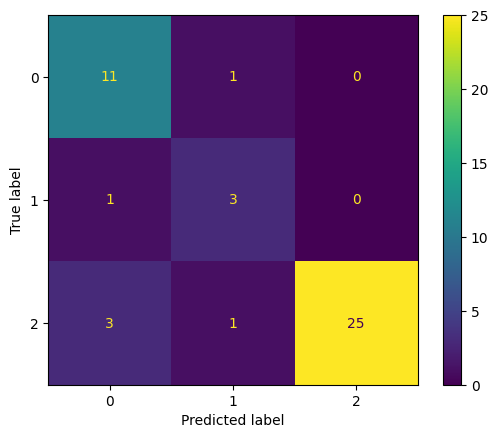

In [105]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.show()

In [106]:
scaled_doc_vectors = [np.average(doc, axis=0) for doc in df["Scaled embeddings"]]

In [107]:
X_scaled = np.array(scaled_doc_vectors)

In [108]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [109]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-03 12:08:05,014] A new study created in memory with name: no-name-1ec5b414-e5e6-43f6-b719-a317ecfd8545
[I 2023-01-03 12:08:05,033] Trial 0 finished with value: 0.8666666666666667 and parameters: {'C': 1.4454804676390238, 'c_weight': None}. Best is trial 0 with value: 0.8666666666666667.
[I 2023-01-03 12:08:05,043] Trial 1 finished with value: 0.8888888888888888 and parameters: {'C': 0.19265613527898554, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-01-03 12:08:05,053] Trial 2 finished with value: 0.6 and parameters: {'C': 2.4258308151767863e-05, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-01-03 12:08:05,069] Trial 3 finished with value: 0.8888888888888888 and parameters: {'C': 0.9687679253094338, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.8888888888888888.
[I 2023-01-03 12:08:05,079] Trial 4 finished with value: 0.8888888888888888 and parameters: {'C': 0.02830173696057914, 'c_weight': 'balanc

In [110]:
study.best_params

{'C': 8.091237124889124, 'c_weight': 'balanced'}

In [111]:
study.best_value

0.9111111111111111

In [112]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [113]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [114]:
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

Score: 0.911
Best parameters: {'C': 8.091237124889124, 'c_weight': 'balanced'}
F1: 0.907
Recall: 0.911
Precision: 0.907


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

clf = LogisticRegression(C=8.091237124889124, class_weight="balanced")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=pred, labels=clf.classes_)

In [116]:
acc = accuracy_score(pred, y_test)
recall = recall_score(pred, y_test, average="weighted")
precision = precision_score(pred, y_test, average="weighted")
f1 = f1_score(pred, y_test, average="weighted")

In [117]:
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Score: 0.911
F1: 0.907
Recall: 0.911
Precision: 0.907


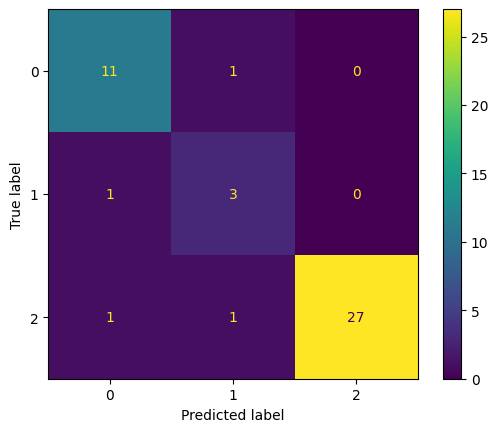

In [118]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.show()